# Sensor Data Fusion
Lecturer: Prof. Baum \
Tutor: Dr. Kolja Thormann \
Semester: Summer 2024
## Homework 8

Assume a robot in 2D-space at position $\begin{bmatrix}x_1 & x_2\end{bmatrix}^T$ moving with velocity $v_1$ in $x_1$ direction and $\dot{x}_2$ in $\dot{x}_2$ direction. Its state is defined as $\textbf{x}=\begin{bmatrix}x_1 & x_2 & \dot{x}_1 & \dot{x}_2\end{bmatrix}^T$.

---
The following tasks will have missing sections marked that you should fill out. 

Missing code parts are marked by
```
# ... code code code
=== YOUR CODE HERE ===

=== END OF YOUR CODE ===
# ... code code code
```
If you are asked to implement a function, make sure to check what variable will be returned by the function and to fill it accordingly. Do not change code outside of the indicated sections.

Furthermore, some questions require theoretical answers instead of python code.

Such questions will have a field marked like this: 

=== YOUR ANSWER HERE === 

In [ ]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
from numpy.linalg import inv, norm

In [ ]:
# variable definitions

t = 1  # length of a time step
steps = 10  # number of steps to run simulation for
x_init = np.array([0, 0, 2, 2])  # inital mean for x

# acceleration noise matrix
Q = np.eye(4)*0.01

# measurement noise matrix
R = np.array([
    [0.2, 0],
    [0, 0.2]
])

# inital covariance for x
# x_cov (=C_init) is just np.eye, but incase you want to try different values, change them here:
x_cov = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

---
### a)

Formulate a motion model for the robot, assuming independent zero-mean Gaussian noise on each state element with covariance matrix $\textbf{Q}=0.1\textbf{I}_4$. Write a function implementing the model.

In general, the motion model will look like this:

$$
\textbf{x}_{k+1}=\textbf{F}\textbf{x}_k+w_k\text{, with }w_k\sim\mathcal{N}(0, \textbf{Q})
$$


In [ ]:
# define F

# === YOUR CODE HERE ===
F = np.array([
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
])

# === END OF YOUR CODE ===

F = np.array(F)
# make sure F is of the correct shape
assert F.shape ==  (4,4)

Next, you need to implement the motion model.

Hint: for multivariate normal distributions, numpy provides `np.random.multivariate_normal`

In [6]:
def motion_model(x, Q, F):
    """
    Function that implements the motion model.
    :param x: current state
    :param Q: process noise covariance
    :param F: state transition matrix
    :return: x_new, the new state
    """
    x = np.array(x)
    
    # === YOUR CODE HERE ===
    w = np.random.multivariate_normal([0, 0, 0, 0], Q)
    x_new = F @ x + w
    
    # === END OF YOUR CODE ===
    
    return x_new


# Test the function:
x_test = [10, 10, 1, 2]  
print(motion_model(x_test, Q, F))

[11.16127821 11.97500462  0.87106817  1.99943337]


---
### b)
In each time step, a sensor measures the robot's position. Formulate a measurement equation under independent zero-mean Gaussian noise with covariance $\textbf{R}=\begin{bmatrix}0.2 & 0\\0 & 0.2\end{bmatrix}$ and implement it as well.

In general, the measuremen equation will look like this:
$$
y=\textbf{H}\textbf{x}_k + v_k\text{, with }v_k\sim\mathcal{N}(0, \textbf{R})
$$



You will now need to define the measuremement matrix $\textbf{H}$.

In [8]:
# define H

# === YOUR CODE HERE ===

H = [[1, 0, 0, 0], [0, 1, 0, 0]]

# === END OF YOUR CODE ===

H = np.array(H)
# make sure F is of the correct shape
assert H.shape ==  (2,4)

In [9]:
def measurement_model_linear(x, R, H):
    """
    Function that implements the measurement model.
    :param x: current state
    :param R: measurement noise matrix
    :param H: measurement matrix
    :return: y, the measurement
    """
    R = np.array(R)
    
    # === YOUR CODE HERE ===
    v = np.random.multivariate_normal([0, 0], R)
    y = H @ x + v
    
    # === END OF YOUR CODE ===
    
    return y

# Test the function:
x_test = [10, 10, 1, 2] 
print(measurement_model_linear(x_test, R, H))

[10.05380347 10.16705754]


---
### c)
Use the functions from a) and b) to implement a simulation using initial state $\hat{\textbf{x}}_{\text{init}}=\begin{bmatrix}0\text{m} & 0\text{m} & 2\text{ms}^{-1} & 2 \text{ms}^{-1}\end{bmatrix}$, 10 time steps of length 1s, and covariances for the initial state
$$
\textbf{C}_{\text{init}}=\begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{bmatrix}\enspace.
$$

For each run, draw the true state from the prior, i.e. using $\hat{\textbf{x}}_{\text{init}}$ and $\textbf{C}_{\text{init}}$!

In [13]:
def simulation(x_init, x_init_cov, Q, R, F, steps, measurement_model, H=None):
    """
    :param x_init: Initial state
    :param x_init_cov: Initial state covariance matrix
    :param Q: process noise covariance
    :param R: Measurement noise matrix
    :param F: state transition matrix
    :param steps: Number of steps to run the simulation for
    :param measurement_model: Function that takes (x,R,P) and returns a measurement for it
    :param H: measurement matrix (optional parameter, if needed by update function)
    :return: (track, ms) with track being the ground truth track, and ms the measurements produced in the simulation.
    """
    x_dim = len(x_init)
    
    # === YOUR CODE HERE ===
    
    track = np.zeros((steps, x_dim))
    ms = np.zeros((steps-1, R.shape[0]))
    for i in range(steps):
        if i == 0:
            track[i, :] = x_init
        else:
            track[i, :] = motion_model(track[i-1, :], Q, F)
            ms[i-1, :] = measurement_model(track[i, :], R, H)
    
    # === END OF YOUR CODE ===
    
    # track should have "steps" many entries of states of correct dimension
    assert track.shape == (steps, x_dim)  
    
    # one less measurement (no measurement for the initial state) and measurements are of dim len(R)
    assert ms.shape == (steps-1, R.shape[0])  
    
    return track, ms

# simulate track and measurements based on the values defined above
gt, ms = simulation(x_init, x_cov, Q, R, F, steps, measurement_model_linear, H)

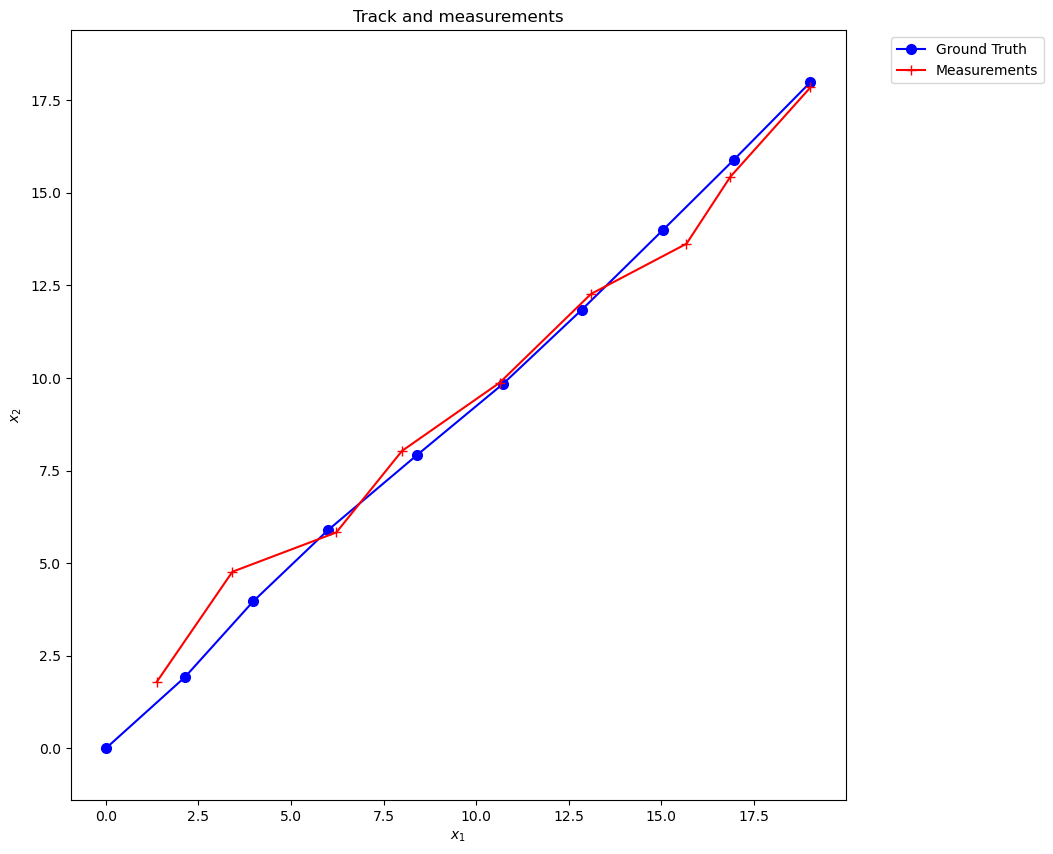

In [14]:
# Visualize the results of the simulation:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o")
ax.plot(ms[:, 0], ms[:, 1], c="r", label="Measurements", markersize=7, marker="+")

ax.axis("equal")
plt.title("Track and measurements")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

---
### d)
Now based on a) and b), implement a predict and an update function for a Kalman filter. Use the Kalman filter to track the robot simulated with your function from c).

Note for the solution:
    
$
\textbf{x}_{k+1|k}=\textbf{F}\textbf{x}_{k|k}
$\
$
\textbf{C}_{k+1|k}=\textbf{F}\textbf{C}_{k|k}\textbf{F}^T + \textbf{Q}
$\
$
\textbf{x}_{k+1|k+1}=\textbf{x}_{k+1|k} + \underbrace{\textbf{C}_{k+1|k}\textbf{H}^T(\overbrace{\textbf{H}\textbf{C}_{k+1|k}\textbf{H}^T + \textbf{R}}^{\textbf{S}})^{-1}}_{\textbf{K}}(y-\textbf{H}\textbf{x}_{k+1|k})
$\
$
\textbf{C}_{k+1|k+1}=\textbf{C}_{k+1|k} - \textbf{K}\textbf{S}\textbf{K}^T
$

In [20]:
def predict(x, x_cov, Q, F):
    """
    Function that implements the predict step of a Kalman Filter.
    :param x: Current state
    :param x_cov: Current state covariance matrix
    :param Q: process noise covariance
    :param F: state transition matrix
    :return: (x_new, x_cov_new) The resulting state and covariance matrix after the predict step
    """
    
    # === YOUR CODE HERE ===
    
    x_new = F @ x
    x_cov_new = F @ x_cov @ F.T + Q
    
    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

In [21]:
def update_linear(x, x_cov, m, R, H):
    """
    Function that implements the update step of a Kalman Filter.
    :param x: Current state
    :param x_cov: Current state covariance matrix
    :param m: Measurement
    :param R: Measurement noise matrix
    :param H: measurement matrix
    :return: (x_new, x_cov_new) The resulting state and covariance matrix after the update step
    """

    # === YOUR CODE HERE ===
    
    x_new  = x + x_cov @ H.T @ inv(H @ x_cov @ H.T + R) @ (m - H @ x)
    x_cov_new = x_cov - x_cov @ H.T @ inv(H @ x_cov @ H.T + R) @ H @ x_cov
    
    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

In [22]:
def kalman_filter(x_init, x_cov, ms, Q, R, F, update, H=None):
    """
    Function that runs the predict and update steps of a kalman filter.
    :param x_init: Initial state
    :param x_cov: Initial state covariance matrix
    :param ms: Measurements 
    :param Q: process nosie covariance
    :param R: Measurement noise matrix
    :param F: state transition matrix
    :param update: update function
    :param H: measurement matrix (optional parameter, if needed by update function)
    :return: track, the resulting track after applying the kalman filter
    """
    # initial track
    track = np.zeros((ms.shape[0]+1,x_init.shape[0]))
    track[0, :] = x_init
    
    for i in range(1, ms.shape[0]+1):
        track[i, :], x_cov = predict(track[i-1, :].T, x_cov, Q, F)
        track[i, :], x_cov = update(track[i, :].T, x_cov, ms[i-1, :].T, R, H)
    
    return track

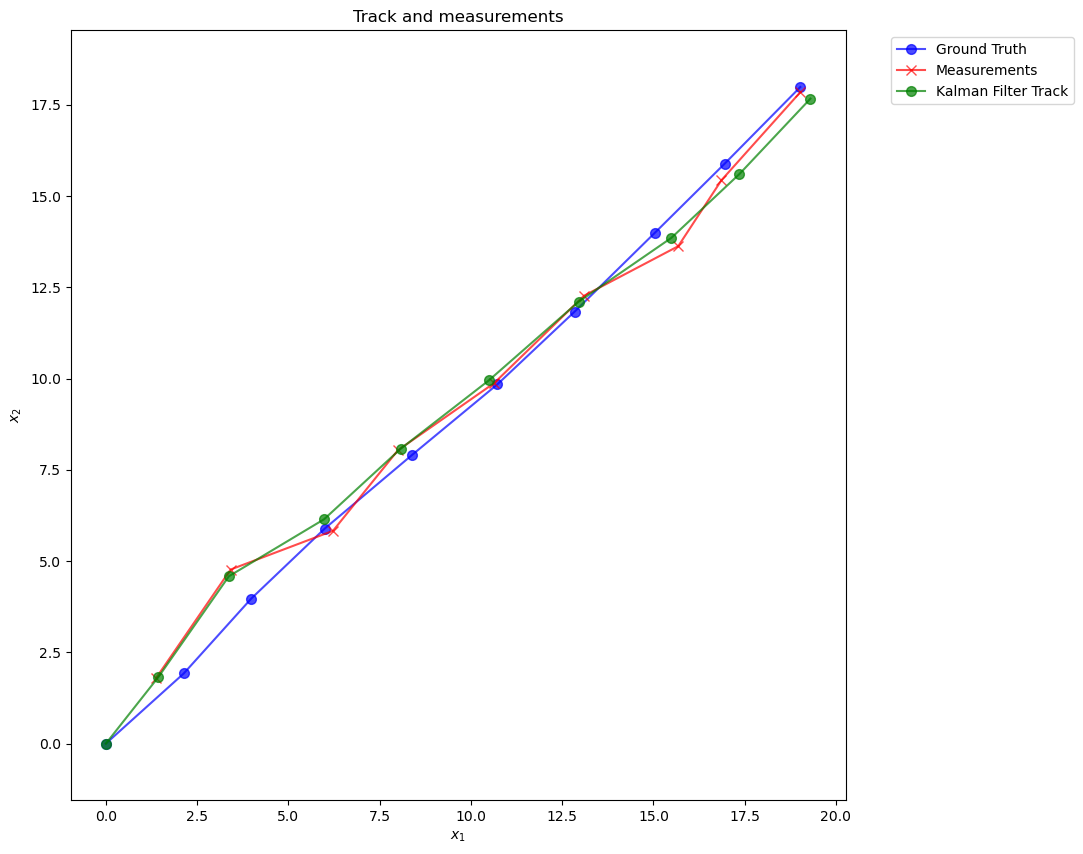

In [23]:
# now, the kalman filter will be applied to the simulation:
track = kalman_filter(x_init, x_cov, ms, Q, R, F, update_linear, H)

# Visualize the results of the simulation and the kalman filter:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o", alpha=0.7)
ax.plot(ms[:, 0], ms[:, 1], c="r", label="Measurements", markersize=7, marker="x", alpha=0.7)
ax.plot(track[:, 0], track[:, 1], c="g", label="Kalman Filter Track", markersize=7, marker="o", alpha=0.7)

ax.axis("equal")
plt.title("Track and measurements")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

---
### e) 
Write a function which calculates the root mean square error (RMSE) of $n=100$ simulation runs with the error as the Euclidean norm at the last time step.

In [24]:
n = 100

def RMSE(n, steps, x_init, x_cov, Q, R, F, measurement, update, H):
    """
    Function that calculates the RMSE of n simulation runs with a fixed number of steps each.
    
    :param n: number of simulation runs to perform
    :param steps: number of steps to run each simulation for
    :param x_init: Initial state for x
    :param x_cov: Initial covariance of x
    :param Q: process nosie covariance
    :param R: Measurement noise matrix
    :param F: state transition matrix
    :param measurement: measurement function of simulation
    :param update: update function of Kalman filter
    :param H: measurement matrix (optional parameter, if needed by measurement/update function)
    :return: error, the RMSE over all runs
    """
    
    # === YOUR CODE HERE ===
    
    error = 0
    for i in range(n):
        gt, ms = simulation(x_init, x_cov, Q, R, F, steps, measurement, H)
        track = kalman_filter(x_init, x_cov, ms, Q, R, F, update, H)
        error += norm(gt[-1] - track[-1])
    error /= n
    
    
    # === END OF YOUR CODE ===
    
    return error
    
error = RMSE(n, steps, x_init, x_cov, Q, R, F, measurement_model_linear, update_linear, H)
print("RMSE over {} runs: {:.4f}".format(n, error))

RMSE over 100 runs: 0.4730


---
### f)
Finally, assume a worse sensor with noise covariance
$$
\textbf{R}_2=\begin{bmatrix}2.0 & 0\\0 & 0.2\end{bmatrix}\enspace.
$$
Calculate the RMSE as in e). To deal with the noise, add a second sensor. Assume the measurements to be independent of each other and update the simulation and Kalman filter accordingly and observe the difference in RMSE. Now, instead of using the same type of sensor, use the sensor with $\textbf{R}_2$ along a second sensor with noise covariance
$$
\textbf{R}_3=\begin{bmatrix}0.2 & 0\\0 & 2.0\end{bmatrix}\enspace.
$$

To this end, two variables need to be (re-)defined: $\textbf{R}$ and $\textbf{H}$\
To avoid confusion, the stacked versions of these variables will be called `R_stack` and `H_stack`.

In [32]:
# Please define R_stack according to the values given in the exercise
# === YOUR CODE HERE ===

#R_stack = np.stack((np.array([[2, 0], [0, 0.2]]), np.array([[0.2, 0], [0, 0.2]])))
R2 = np.array([
    [2.0, 0],
    [0, 0.2]
])

R3 = np.array([
    [0.2, 0],
    [0, 2.0]
])

R_stack = np.block([[R2, np.zeros_like(R2)], [np.zeros_like(R3), R3]])# stack R2 and R3

# === END OF YOUR CODE ===

R_stack = np.array(R_stack)
assert R_stack.shape == (4,4)

# H_stack is simply the vertically stacked version of H
H_stack = np.vstack((H,H))

In [33]:
n = 100
# run the simulation, with the new R_stack consisting of the new sensors R2 and R3
error = RMSE(n, steps, x_init, x_cov, Q, R2, F, measurement_model_linear, update_linear, H)
print("RMSE over {} runs: {:.4f}".format(n, error))

RMSE over 100 runs: 0.8100


In [34]:
n = 100
# run the simulation, with the new R_stack consisting of the new sensors R2 and R3
error = RMSE(n, steps, x_init, x_cov, Q, R_stack, F, measurement_model_linear, update_linear, H_stack)
print("RMSE over {} runs: {:.4f}".format(n, error))

ValueError: mean and cov must have same length

---
## Bonus

---
### B.a)
This time, instead of measuring the position directly, we measure the distance to a landmark $P_i$. Formulate the measurement equation and write a function implementing it. We do not provide a measurement matrix H this time, but instead the landmark P.

For now, we will assume only a single landmark is used. In that case, the measurement noise will be a 1x1 matrix.

=== YOUR ANSWER HERE ===

$$
h_i(\textbf{x})=\sqrt{(x_1-P_{i,1})^2+(x_2-P_{i,2})^2}
$$

In [ ]:
def measurement_model_nonlinear_single(x, R, P):
    """
    Implements the measurement model for a single landmark.
    
    :param x: Robot location
    :param R: measurement Noise matrix. If only one landmark exists, will be of shape (1,1)
    :param P: landmark locations
    :return m: The measurement
    """
    
    assert R.shape == (1,1)
    
    # === YOUR CODE HERE ===
    

    
    # === END OF YOUR CODE ===
    
    return m

---
### B.b)
To use the measurement in the Kalman filter, we utilize the EKF formulas. Calculate the Jacobian of the measurement function from a) and implement the EKF measurement update.

Again, we assume that for now only one landmark exists, and $\textbf{R}$ will be a 1x1 matrix. 

=== YOUR ANSWER HERE ===

$$
\textbf{H}_i=\begin{bmatrix}\frac{x_1-P_{i,1}}{\sqrt{(x_1-P_{i,1})^2+(x_2-P_{i,2})^2}} & \frac{x_2-P_{i,2}}{\sqrt{(x_1-P_{i,1})^2+(x_2-P_{i,2})^2}} & 0 & 0\end{bmatrix}
$$

In [ ]:
def update_nonlinear_single(x, x_cov, m, R, P):
    """
    Measurement update of the EKF for the case that there is one landmark.
    
    :param x: robot state
    :param x_cov: robot state covariance
    :param m: measurement
    :param R: measurement noise matrix
    :param P: landmark locations
    :return: (x_new, x_cov_new) the updated robot state and state covariance
    """
    # ensure everything is numpy
    x = np.array(x)
    x_cov = np.array(x_cov)
    m = np.array(m)
    R = np.array(R)
    P = np.array(P)
    
    assert R.shape == (1,1)
    # === YOUR CODE HERE ===
    
    

    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

---
The simulation will now be run using the previous functions and the results will be visualized. We assume the landmark to be $P_1=\begin{bmatrix}0, -5\end{bmatrix}^{\text{T}}$ and the measurement noise is $\mathbf{R}=\begin{bmatrix}0.1\end{bmatrix}$.

In [ ]:
# init variables and run simulation:

t = 1
steps = 10
n = 100

x_init = np.array([0, 0, 0.5, 0.5])
x_cov = np.array([
    [0.1, 0, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])

Q = np.array([
    [0.001, 0, 0, 0],
    [0, 0.001, 0, 0],
    [0, 0, 0.02, 0],
    [0, 0, 0, 0.02]
])

R = np.array([[0.1]])

F = np.array([
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

P = np.array([[0, -5]])
# run simulation
gt, ms = simulation(x_init, x_cov, Q, R, F, steps, measurement_model_nonlinear_single, P)
track = kalman_filter(x_init, x_cov, ms, Q, R, F, update_nonlinear_single, P)

# Visualize the results of the simulation:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o")
ax.plot(track[:, 0], track[:, 1], c="g", label="EKF Track", markersize=7, marker="o")
ax.scatter(P[:, 0], P[:, 1], c="r", label="Landmark location", marker="x")

for i, lm in enumerate(ms.T):
    # get the measurement for the first landmark
    for y in lm:
        c = plt.Circle((P[i, 0], P[i, 1]), y, color='r', fill=False)
        ax.add_artist(c)

ax.axis("equal")
plt.title("Track and measurements")
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='red'))
labels.append("Measurements")
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

---
### B.c)
To improve your estimate, use a second landmark $P_2=\begin{bmatrix}-5 & 0\end{bmatrix}^T$. Formulate a stacked measurement equation and calculate the corresponding Jacobian.

You will need to implement new versions of your `measurement_model` and your `update` functions. 

Hints:
- since we are now dealing with a multi-dimensional scenario, you should consider using `np.random.multivariate_normal` instead of `np.random.normal`.
- make sure you calculate the distances between x and P across the correct axis, since P is now multi-dimensional too.

In [ ]:
def measurement_model_dual(x, R, P):
    """
    Implements the measurement model for the two landmark case.
    
    :param x: Robot location
    :param R: measurement Noise matrix. If two landmarks exists, will be of shape (2,2)
    :param P: landmark locations
    :return m: The measurement
    """
    assert R.shape == (2,2)
    
    # === YOUR CODE HERE ===
    
    # need to make sure we take the correct axis for the norm!
    
    
    # === END OF YOUR CODE ===
    
    return m

In [ ]:
def update_dual(x, x_cov, m, R, P):
    """
    Measurement update of the EKF for the case that there are two landmarks.
    
    :param x: robot state
    :param x_cov: robot state covariance
    :param m: measurement
    :param R: measurement noise matrix
    :param P: landmark locations
    :return: (x_new, x_cov_new) the updated robot state and state covariance
    """
    # ensure everything is numpy
    x = np.array(x)
    x_cov = np.array(x_cov)
    m = np.array(m)
    R = np.array(R)
    P = np.array(P)
    
    assert R.shape == (2,2)
    
    # === YOUR CODE HERE ===
    
    

    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

In [ ]:
# init variables and run simulation:

t = 1
steps = 10
n = 100

x_init = np.array([0, 0, 0.5, 0.5])
x_cov = np.array([
    [0.1, 0, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])

Q = np.array([
    [0.001, 0, 0, 0],
    [0, 0.001, 0, 0],
    [0, 0, 0.02, 0],
    [0, 0, 0, 0.02]
])

R = np.array([
    [0.1, 0],
    [0, 0.1]
])

F = np.array([
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

P = np.array([
    [0, -5],
    [-5, 0]
])

# run simulation
gt, ms = simulation(x_init, x_cov, Q, R, F, steps, measurement_model_dual, P)
track = kalman_filter(x_init, x_cov, ms, Q, R, F, update_dual, P)

# Visualize the results of the simulation:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o")
ax.plot(track[:, 0], track[:, 1], c="g", label="EKF Track", markersize=7, marker="o")
ax.scatter(P[0, 0], P[0, 1], c="r", label="Landmark location", marker="x")
ax.scatter(P[1, 0], P[1, 1], c="orange", label="Landmark location", marker="x")

lm_c = ["red", "orange"]
for i, lm in enumerate(ms.T):
    # get the measurement for the first landmark
    for y in lm:
        c = plt.Circle((P[i, 0], P[i, 1]), y, color=lm_c[i], fill=False)
        ax.add_artist(c)

ax.axis("equal")
plt.title("Track and measurements")
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='red'))
labels.append("Measurements (Sensor 1)")
handles.append(mlines.Line2D([], [], color='orange'))
labels.append("Measurements (Sensor 2)")
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()